## Learn model
## Content
  * Load data
  * Select features
  * Learning
    * linear
    * lasso
    * ridge
    * elastic net
    * Xgboost
    * MLP
  * Compare results

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from pymongo import MongoClient
from keras import metrics
import warnings
import sklearn.linear_model as linear_model
import sklearn.ensemble as ensemble
import sklearn.neighbors as neighbors
import sklearn.svm as svm

%matplotlib inline

warnings.filterwarnings('ignore')

/home/siarhei/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
MONGODB_URL = os.environ['KC_MONGODB_URI']
client = MongoClient(MONGODB_URL)
db = client.get_default_database()

In [3]:
data = db["notebook"].find({})
full_frame = pd.DataFrame(list(data))
full_frame.drop(columns=["_id"], inplace=True)
full_frame.shape

(21613, 21)

### Select features

In [4]:
features = [
    'grade',
    'sqft_living',
    'sqft_living15',
    'sqft_above',
    'bathrooms',
    'lat',
    'view',
    'bedrooms',
    'sqft_basement',
    'floors',
    'waterfront',
    'yr_renovated']

to_log_transform = ['lat', 'floors']

to_pow_transform = ['sqft_basement']

to_boolean_transform = {
    'floors': {'new_feature_name': 'Has2ndFloor', 'threshold': 1},
}

## Learn model

In [5]:
def log_transformation(frame, feature):
    new_feature_name = new_log_feature_name(feature)
    frame[new_feature_name] = np.log1p(frame[feature].values)

def new_quadratic_feature_name(feature):
    return feature+'2'

def new_log_feature_name(feature):
    return feature+'Log'
    
def quadratic(frame, feature):
    new_feature_name = new_quadratic_feature_name(feature)
    frame[new_feature_name] = frame[feature]**2
    
def boolean_transformation(frame, feature, new_feature_name, threshold):
    frame[new_feature_name] = frame[feature].apply(lambda x: 1 if x > threshold else 0)
    
def error(actual, predicted):
    actual = np.log(actual)
    predicted = np.log(predicted)
    return np.sqrt(np.sum(np.square(actual-predicted))/len(actual))

def error_mse(actual, predicted):
    actual = (actual)
    predicted = (predicted)
    return np.sqrt(np.sum(np.square(actual-predicted))/len(actual))

In [6]:
added_boolean_columns = [to_boolean_transform[o]['new_feature_name'] for o in to_boolean_transform.keys()]

added_quadratic_columns = list(map(new_quadratic_feature_name, to_pow_transform))

added_log_columns = list(map(new_log_feature_name, to_log_transform))

def transform_before_learn(frame, to_log_transform, to_pow_transform, to_boolean_transform):

    for c in to_log_transform:
        log_transformation(frame, c)

    for c in to_pow_transform:
        quadratic(frame, c)

    for c in to_boolean_transform.keys():
        boolean_transformation(frame, c, to_boolean_transform[c]['new_feature_name'], 
                               to_boolean_transform[c]['threshold']) 


transform_before_learn(full_frame, to_log_transform, to_pow_transform, to_boolean_transform)

df_train = full_frame[:1460]
df_test = full_frame[1460:]

# features = list(set(features) - set(to_log_transform) - set(to_pow_transform))

In [7]:
features_full_list = features + added_boolean_columns + added_quadratic_columns + added_log_columns

## Out liars

In [8]:
df_train_cleaned = df_train
#df_train_cleaned = df_train.drop(df_train[df_train['Id'] == 1299].index)
#df_train_cleaned = df_train.drop(df_train[df_train['Id'] == 524].index)

### LinearRegression

In [9]:
X = df_train_cleaned[features_full_list]
Y = df_train_cleaned['SalePrice'].values

full_X = df_train[features_full_list]
full_Y = df_train['SalePrice'].values

linear = linear_model.LinearRegression()
linear.fit(X, np.log1p(Y))

Ypred_linear = np.expm1(linear.predict(full_X))
print(error(full_Y, Ypred_linear))
print(error_mse(full_Y, Ypred_linear))

0.21473419806832905
189383.3677974608


#### test dataset

In [10]:
full_test_X = df_test[features_full_list]
test_Y = df_test['SalePrice'].values

test_pred = np.expm1(linear.predict(full_test_X))

print(error(test_Y, test_pred))
print(error_mse(test_Y, test_pred))

0.2724068604056992
196741.60325415875


### LassoCV

In [11]:
X = df_train_cleaned[features_full_list]
Y = df_train_cleaned['SalePrice'].values

full_X = df_train[features_full_list]
full_Y = df_train['SalePrice'].values

lasso = linear_model.LassoCV()
lasso.fit(X, np.log1p(Y))

Ypred_lasso = np.expm1(lasso.predict(full_X))
print(error(full_Y, Ypred_lasso))
print(error_mse(full_Y, Ypred_linear))

0.3491530412157379
189383.3677974608


#### test dataset

In [12]:
full_test_X = df_test[features_full_list]
test_Y = df_test['SalePrice'].values

test_pred = np.expm1(lasso.predict(full_test_X))

print(error(test_Y, test_pred))
print(error_mse(test_Y, test_pred))

0.41446934814331354
822685.405465775


### RidgeCV

In [13]:
X = df_train_cleaned[features_full_list]
Y = df_train_cleaned['SalePrice'].values

full_X = df_train[features_full_list]
full_Y = df_train['SalePrice'].values

ridge = linear_model.RidgeCV()
ridge.fit(X, np.log1p(Y))
Ypred_ridge = np.expm1(ridge.predict(full_X))
print(error(full_Y,Ypred_ridge))
print(error_mse(full_Y, Ypred_ridge))

0.25222365544354375
364938.12307145324


#### test dataset

In [14]:
full_test_X = df_test[features_full_list]
test_Y = df_test['SalePrice'].values

test_pred = np.expm1(ridge.predict(full_test_X))

print(error(test_Y, test_pred))
print(error_mse(test_Y, test_pred))

0.31857305927412205
2474346.419869392


### ElasticNetCV

In [15]:
X = df_train_cleaned[features_full_list]
Y = df_train_cleaned['SalePrice'].values

full_X = df_train[features_full_list]
full_Y = df_train['SalePrice'].values

elasticNet = linear_model.ElasticNetCV()
elasticNet.fit(X, np.log1p(Y))
Ypred_elasticNet = np.expm1(elasticNet.predict(full_X))
print(error(full_Y,Ypred_elasticNet))
print(error_mse(full_Y, Ypred_elasticNet))

0.3491598770378438
294437.594635878


#### test dataset

In [16]:
full_test_X = df_test[features_full_list]
test_Y = df_test['SalePrice'].values

test_pred = np.expm1(elasticNet.predict(full_test_X))

print(error(test_Y, test_pred))
print(error_mse(test_Y, test_pred))

0.41447838688678496
822881.9548808997


### Xgboost

In [17]:
import xgboost as xgb

In [18]:
X = df_train_cleaned[features_full_list]
Y = df_train_cleaned['SalePrice'].values

full_X = df_train[features_full_list]
full_Y = df_train['SalePrice'].values

In [19]:
X_tr, X_val, y_tr, y_val = train_test_split(X, np.log1p(Y), random_state = 42, test_size=0.20)

eval_set = [(X_val, y_val)]

In [20]:
model_xgb = xgb.XGBRegressor(n_estimators=1000, max_depth=2, learning_rate=0.1)
model_xgb.fit(X_tr, y_tr, eval_metric="rmse", early_stopping_rounds=500, eval_set=eval_set, verbose=True)
# model_xgb.fit(X, np.log1p(Y))

[0]	validation_0-rmse:11.3531
Will train until validation_0-rmse hasn't improved in 500 rounds.
[1]	validation_0-rmse:10.2159
[2]	validation_0-rmse:9.19525
[3]	validation_0-rmse:8.27665
[4]	validation_0-rmse:7.4489
[5]	validation_0-rmse:6.70133
[6]	validation_0-rmse:6.03187
[7]	validation_0-rmse:5.42892
[8]	validation_0-rmse:4.8869
[9]	validation_0-rmse:4.39591
[10]	validation_0-rmse:3.95831
[11]	validation_0-rmse:3.56315
[12]	validation_0-rmse:3.209
[13]	validation_0-rmse:2.88699
[14]	validation_0-rmse:2.60044
[15]	validation_0-rmse:2.34268
[16]	validation_0-rmse:2.11033
[17]	validation_0-rmse:1.9016
[18]	validation_0-rmse:1.71402
[19]	validation_0-rmse:1.54425
[20]	validation_0-rmse:1.39237
[21]	validation_0-rmse:1.25636
[22]	validation_0-rmse:1.13439
[23]	validation_0-rmse:1.02559
[24]	validation_0-rmse:0.926595
[25]	validation_0-rmse:0.838844
[26]	validation_0-rmse:0.759447
[27]	validation_0-rmse:0.689839
[28]	validation_0-rmse:0.627963
[29]	validation_0-rmse:0.572951
[30]	validati

[252]	validation_0-rmse:0.193764
[253]	validation_0-rmse:0.193709
[254]	validation_0-rmse:0.193801
[255]	validation_0-rmse:0.193804
[256]	validation_0-rmse:0.193792
[257]	validation_0-rmse:0.193641
[258]	validation_0-rmse:0.193873
[259]	validation_0-rmse:0.193992
[260]	validation_0-rmse:0.193957
[261]	validation_0-rmse:0.193997
[262]	validation_0-rmse:0.193942
[263]	validation_0-rmse:0.193972
[264]	validation_0-rmse:0.194126
[265]	validation_0-rmse:0.194137
[266]	validation_0-rmse:0.194434
[267]	validation_0-rmse:0.194527
[268]	validation_0-rmse:0.194533
[269]	validation_0-rmse:0.194646
[270]	validation_0-rmse:0.194504
[271]	validation_0-rmse:0.194493
[272]	validation_0-rmse:0.194542
[273]	validation_0-rmse:0.194514
[274]	validation_0-rmse:0.194494
[275]	validation_0-rmse:0.194347
[276]	validation_0-rmse:0.194433
[277]	validation_0-rmse:0.194403
[278]	validation_0-rmse:0.194432
[279]	validation_0-rmse:0.194415
[280]	validation_0-rmse:0.194512
[281]	validation_0-rmse:0.194504
[282]	vali

[501]	validation_0-rmse:0.197478
[502]	validation_0-rmse:0.19735
[503]	validation_0-rmse:0.197388
[504]	validation_0-rmse:0.197291
[505]	validation_0-rmse:0.197309
[506]	validation_0-rmse:0.197341
[507]	validation_0-rmse:0.197415
[508]	validation_0-rmse:0.197413
[509]	validation_0-rmse:0.197414
[510]	validation_0-rmse:0.197326
[511]	validation_0-rmse:0.197364
[512]	validation_0-rmse:0.197314
[513]	validation_0-rmse:0.197355
[514]	validation_0-rmse:0.197437
[515]	validation_0-rmse:0.197446
[516]	validation_0-rmse:0.197322
[517]	validation_0-rmse:0.197331
[518]	validation_0-rmse:0.19733
[519]	validation_0-rmse:0.197185
[520]	validation_0-rmse:0.197317
[521]	validation_0-rmse:0.197343
[522]	validation_0-rmse:0.197399
[523]	validation_0-rmse:0.197489
[524]	validation_0-rmse:0.197461
[525]	validation_0-rmse:0.19741
[526]	validation_0-rmse:0.197328
[527]	validation_0-rmse:0.197347
[528]	validation_0-rmse:0.19743
[529]	validation_0-rmse:0.197398
[530]	validation_0-rmse:0.197397
[531]	validati

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=2, min_child_weight=1, missing=None, n_estimators=1000,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [21]:
Ypred_xgb = np.expm1(model_xgb.predict(full_X))
print(error(full_Y, Ypred_xgb))
print(error_mse(full_Y, Ypred_xgb))

0.13280988268025357
112997.66762242946


#### test dataset

In [22]:
full_test_X = df_test[features_full_list]
test_Y = df_test['SalePrice'].values

test_pred = np.expm1(model_xgb.predict(full_test_X))

print(error(test_Y, test_pred))
print(error_mse(test_Y, test_pred))

0.24110465357350375
197307.14448948618


## MLP

In [23]:
import tensorflow as tf
from keras.layers import Dense
from keras.models import Sequential
from keras.regularizers import l1
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint 
from keras.callbacks import LearningRateScheduler
from keras import optimizers
from sklearn.preprocessing import StandardScaler
from keras import backend as K
from keras import losses

tf.logging.set_verbosity(tf.logging.ERROR)
tf.set_random_seed(42)
np.random.seed(42)

In [24]:
mlp_feed = df_train[features]

In [25]:
X_tr, X_val, y_tr, y_val = train_test_split(mlp_feed, np.log1p(Y), random_state = 7, test_size=0.20)

In [26]:
model = Sequential()
model.add(Dense(10, input_dim=mlp_feed.shape[1], activation='relu'))
model.add(Dense(30, activation='relu'))
model.add(Dense(40, activation='relu'))
model.add(Dense(1))

# adam = optimizers.Adam()
# model.compile(loss = losses.mean_squared_error, optimizer = adam)

model.compile(optimizer ='adam', loss = 'mean_squared_error', metrics =[metrics.mae])

In [27]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 10)                130       
_________________________________________________________________
dense_2 (Dense)              (None, 30)                330       
_________________________________________________________________
dense_3 (Dense)              (None, 40)                1240      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 41        
Total params: 1,741
Trainable params: 1,741
Non-trainable params: 0
_________________________________________________________________


In [28]:
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=20, verbose=1, mode='auto')
checkpointer = ModelCheckpoint(filepath="best_weights.hdf5", verbose=0, save_best_only=True)  # save best model

In [29]:
hist = model.fit(X_tr, y_tr, 
                 batch_size=1, 
                 validation_data = (X_val, y_val), 
                 callbacks=[monitor, checkpointer], 
                 verbose=1, 
                 epochs=150)

Train on 1168 samples, validate on 292 samples
Epoch 1/150
1168/1168 [==============================] - 5s 5ms/step - loss: 720.0555 - mean_absolute_error: 9.2509 - val_loss: 30.5687 - val_mean_absolute_error: 3.6748
Epoch 2/150
1168/1168 [==============================] - 6s 5ms/step - loss: 39.8070 - mean_absolute_error: 4.5564 - val_loss: 17.3796 - val_mean_absolute_error: 2.9956
Epoch 3/150
1168/1168 [==============================] - 6s 5ms/step - loss: 32.1639 - mean_absolute_error: 4.0417 - val_loss: 23.9586 - val_mean_absolute_error: 4.1662
Epoch 4/150
1168/1168 [==============================] - 6s 5ms/step - loss: 43.9372 - mean_absolute_error: 4.0778 - val_loss: 8.3734 - val_mean_absolute_error: 2.1008
Epoch 5/150
1168/1168 [==============================] - 5s 5ms/step - loss: 16.2758 - mean_absolute_error: 2.8962 - val_loss: 20.7302 - val_mean_absolute_error: 2.8603
Epoch 6/150
1168/1168 [==============================] - 5s 5ms/step - loss: 14.3931 - mean_absolute_error: 

1168/1168 [==============================] - 6s 5ms/step - loss: 0.2164 - mean_absolute_error: 0.3524 - val_loss: 0.0967 - val_mean_absolute_error: 0.2341
Epoch 50/150
1168/1168 [==============================] - 6s 5ms/step - loss: 0.1865 - mean_absolute_error: 0.3276 - val_loss: 0.1891 - val_mean_absolute_error: 0.3369
Epoch 51/150
1168/1168 [==============================] - 6s 5ms/step - loss: 0.2279 - mean_absolute_error: 0.3629 - val_loss: 0.1977 - val_mean_absolute_error: 0.3650
Epoch 52/150
1168/1168 [==============================] - 6s 5ms/step - loss: 0.2207 - mean_absolute_error: 0.3527 - val_loss: 0.1893 - val_mean_absolute_error: 0.3124
Epoch 53/150
1168/1168 [==============================] - 6s 5ms/step - loss: 0.1724 - mean_absolute_error: 0.3181 - val_loss: 0.1277 - val_mean_absolute_error: 0.2695
Epoch 54/150
1168/1168 [==============================] - 6s 5ms/step - loss: 0.2035 - mean_absolute_error: 0.3402 - val_loss: 0.1342 - val_mean_absolute_error: 0.2797
Epoch

In [30]:
model.load_weights('best_weights.hdf5')  # load weights from best model

# Measure accuracy
Ypred_mlp = np.expm1(model.predict(mlp_feed))
print(error(df_train['SalePrice'].values,Ypred_mlp))
print(error_mse(df_train['SalePrice'].values, Ypred_mlp))

25.041547305453207
20989842.58853919


#### test dataset

In [31]:
full_test_X = df_test[features]
test_Y = df_test['SalePrice'].values

test_pred = np.expm1(model.predict(full_test_X))

print(error(test_Y, test_pred))
print(error_mse(test_Y, test_pred))

108.42402878063507
302852856.0765838


### RandomForest

In [32]:
X = df_train_cleaned[features_full_list]
Y = df_train_cleaned['SalePrice'].values

full_X = df_train[features_full_list]
full_Y = df_train['SalePrice'].values

randomForest = ensemble.RandomForestRegressor(n_estimators=100)
randomForest.fit(X, np.log1p(Y))
Ypred_randomForest = np.expm1(randomForest.predict(full_X))
print(error(full_Y,Ypred_randomForest))
print(error_mse(full_Y, Ypred_randomForest))

0.07009733189536754
78524.05141285651


#### test dataset

In [33]:
full_test_X = df_test[features_full_list]
test_Y = df_test['SalePrice'].values

test_pred = np.expm1(randomForest.predict(full_test_X))

print(error(test_Y, test_pred))
print(error_mse(test_Y, test_pred))

0.24505233919431094
204323.7161365343


### KNeighbors

In [34]:
X = df_train_cleaned[features_full_list]
Y = df_train_cleaned['SalePrice'].values

full_X = df_train[features_full_list]
full_Y = df_train['SalePrice'].values

knn = neighbors.KNeighborsRegressor()
knn.fit(X, np.log1p(Y))
Ypred_knn = np.expm1(knn.predict(full_X))
print(error(full_Y,Ypred_knn))
print(error_mse(full_Y, Ypred_knn))

0.29462875468733285
247481.4933400999


#### test dataset

In [35]:
full_test_X = df_test[features_full_list]
test_Y = df_test['SalePrice'].values

test_pred = np.expm1(knn.predict(full_test_X))

print(error(test_Y, test_pred))
print(error_mse(test_Y, test_pred))

0.47424494735900696
322043.9033543209


### SVR

In [36]:
X = df_train_cleaned[features_full_list]
Y = df_train_cleaned['SalePrice'].values

full_X = df_train[features_full_list]
full_Y = df_train['SalePrice'].values

svr = svm.SVR()
svr.fit(X, np.log1p(Y))
Ypred_svr = np.expm1(svr.predict(full_X))
print(error(full_Y,Ypred_svr))
print(error_mse(full_Y, Ypred_svr))

0.12440581903793556
160449.9914878443


#### test dataset

In [37]:
full_test_X = df_test[features_full_list]
test_Y = df_test['SalePrice'].values

test_pred = np.expm1(svr.predict(full_test_X))

print(error(test_Y, test_pred))
print(error_mse(test_Y, test_pred))

0.5404044439501173
365521.5278703551


## Compare results

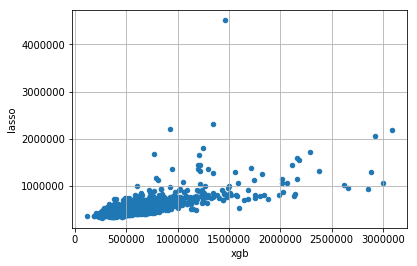

In [38]:
predictions = pd.DataFrame({"xgb":Ypred_xgb, "lasso":Ypred_lasso})
predictions.plot(x = "xgb", y = "lasso", kind = "scatter", grid=True)

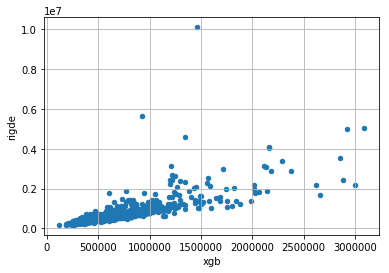

In [39]:
predictions = pd.DataFrame({"xgb":Ypred_xgb, "rigde":Ypred_ridge})
predictions.plot(x = "xgb", y = "rigde", kind = "scatter", grid=True)

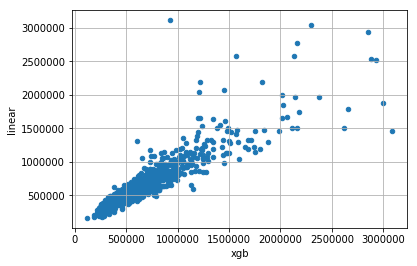

In [40]:
predictions = pd.DataFrame({"xgb":Ypred_xgb, "linear":Ypred_linear})
predictions.plot(x = "xgb", y = "linear", kind = "scatter", grid=True)

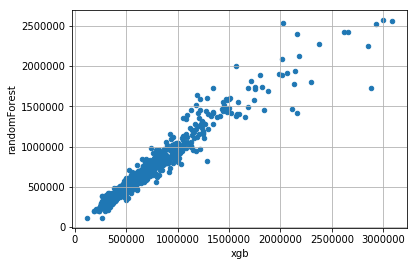

In [41]:
predictions = pd.DataFrame({"xgb":Ypred_xgb, "randomForest":Ypred_randomForest})
predictions.plot(x = "xgb", y = "randomForest", kind = "scatter", grid=True)

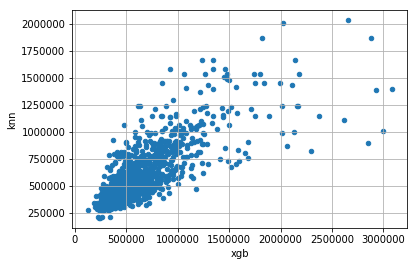

In [42]:
predictions = pd.DataFrame({"xgb":Ypred_xgb, "knn":Ypred_knn})
predictions.plot(x = "xgb", y = "knn", kind = "scatter", grid=True)

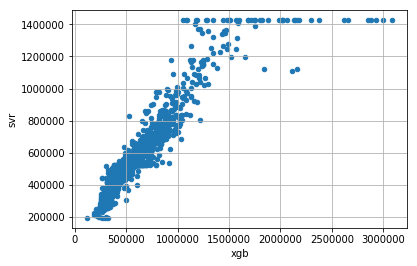

In [43]:
predictions = pd.DataFrame({"xgb":Ypred_xgb, "svr":Ypred_svr})
predictions.plot(x = "xgb", y = "svr", kind = "scatter", grid=True)